In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Prep:

### Data download

In [3]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    transform = ToTensor(),
    download = True
)

In [4]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
classes_names = train_data.classes
classes_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### Data Loader

In [6]:
train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
)

In [7]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 1, 28, 28])

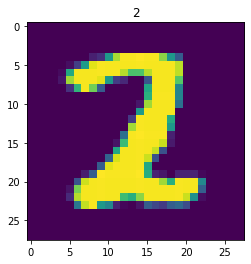

In [8]:
data, label = next(iter(train_dataloader))
plt.title(f"{label[0]}")
plt.imshow(data[0].squeeze());

## Designing a Model

In [9]:
class TinyVGG(nn.Module):
  def __init__(self,inp,hid,out):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(inp,hid,3,stride=1),
        nn.ReLU(),
        nn.Conv2d(hid,hid,3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
        )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hid,hid,3,stride=1),
        nn.ReLU(),
        nn.Conv2d(hid,hid,3,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hid*16,out)
    )
  def forward(self, x):
    return self.classifier(self.block_2(self.block_1(x)))


In [10]:
model = TinyVGG(1,10,10).to(device)
model

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [11]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import torchinfo

from torchinfo import summary

summary(model, input_size=[1,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 12, 12]           --
│    └─Conv2d: 2-1                       [1, 10, 26, 26]           100
│    └─ReLU: 2-2                         [1, 10, 26, 26]           --
│    └─Conv2d: 2-3                       [1, 10, 24, 24]           910
│    └─ReLU: 2-4                         [1, 10, 24, 24]           --
│    └─MaxPool2d: 2-5                    [1, 10, 12, 12]           --
├─Sequential: 1-2                        [1, 10, 4, 4]             --
│    └─Conv2d: 2-6                       [1, 10, 10, 10]           910
│    └─ReLU: 2-7                         [1, 10, 10, 10]           --
│    └─Conv2d: 2-8                       [1, 10, 8, 8]             910
│    └─ReLU: 2-9                         [1, 10, 8, 8]             --
│    └─MaxPool2d: 2-10                   [1, 10, 4, 4]             --
├─Sequentia

## Loss, ACC & Optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()

acc_fn = Accuracy().cuda()

optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

## Training Loop

In [14]:
from tqdm.auto import tqdm

In [15]:
epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"{epoch}\n---------")
  train_loss, train_acc, test_loss, test_acc = 0,0,0,0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    acc = acc_fn(y_pred.argmax(dim=1),y)
    train_loss += loss
    train_acc += acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      loss = loss_fn(test_pred, y_test)
      acc = acc_fn(test_pred.argmax(dim=1), y_test)
      test_loss += loss
      test_acc += acc

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"{train_loss} /// {train_acc} /// {test_loss} /// {test_acc}")

  0%|          | 0/10 [00:00<?, ?it/s]

0
---------
1.7937180995941162 /// 0.33640000224113464 /// 0.2976594567298889 /// 0.910243570804596
1
---------
0.1923922747373581 /// 0.9408167004585266 /// 0.1078747883439064 /// 0.9691493511199951
2
---------
0.11807030439376831 /// 0.9641667008399963 /// 0.0887390673160553 /// 0.9723442196846008
3
---------
0.09546135365962982 /// 0.9707666635513306 /// 0.07433885335922241 /// 0.9743410348892212
4
---------
0.08328551799058914 /// 0.9741666913032532 /// 0.06570342183113098 /// 0.9794328808784485
5
---------
0.07403573393821716 /// 0.9774667024612427 /// 0.06338267773389816 /// 0.979632556438446
6
---------
0.0671573355793953 /// 0.9794666767120361 /// 0.057382501661777496 /// 0.9824280738830566
7
---------
0.061755482107400894 /// 0.9811000227928162 /// 0.059498630464076996 /// 0.9812300205230713
8
---------
0.058398790657520294 /// 0.9817833304405212 /// 0.05809483304619789 /// 0.9816293716430664
9
---------
0.05523772910237312 /// 0.9829333424568176 /// 0.052651744335889816 /// 0